<a href="https://colab.research.google.com/github/hhhezhang/llama-from-scratch-with-flax/blob/main/llama_flax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLaMA From Scratch With Flax

In [8]:
import jax

MASTER_CONFIG = {}
jax.devices()

[CpuDevice(id=0)]

## Dataset

In [36]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

tiny_shakespear = tfds.load(name='tiny_shakespeare')
lines = next(iter(tiny_shakespear['train']))['text'].numpy()
vocab = sorted(list(set(np.frombuffer(lines, dtype='S1'))))

In [17]:
encode_tf = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)

chars_from_ids_tf = tf.keras.layers.StringLookup(
    vocabulary=encode_tf.get_vocabulary(), invert=True, mask_token=None)

def decode_tf(ids):
    return tf.strings.reduce_join(chars_from_ids_tf(ids), axis=-1)

print('vocab size:', len(encode_tf.get_vocabulary()))
MASTER_CONFIG['vocab_size'] = len(encode_tf.get_vocabulary())
decode_tf(encode_tf(np.frombuffer(b'hello', dtype='S1')))

vocab size: 66


<tf.Tensor: shape=(), dtype=string, numpy=b'hello'>

In [13]:
def get_batches(dataset, split, batch_size, context_window, config=MASTER_CONFIG):
    d = dataset[split]
    d = d.map(lambda x: tf.strings.unicode_split(x['text'], 'UTF-8'))
    d = d.map(lambda x: encode_tf(x))
    d = d.unbatch()
    d = d.batch(context_window+1, drop_remainder=True)
    d = d.map(lambda x: (x[:-1], x[1:]))
    d = d.shuffle(1000000)
    d = d.batch(batch_size, drop_remainder=True)
    d = d.repeat()
    d = d.prefetch(tf.data.experimental.AUTOTUNE)
    return tfds.as_numpy(d)

MASTER_CONFIG.update({
    'context_window': 16
})

for x, y in get_batches(tiny_shakespear,
                        'train',
                        8,
                        MASTER_CONFIG['context_window']):
    print(decode_tf(x), decode_tf(y))
    break

tf.Tensor(
[b'akes this spoil.' b'hin your walls?\n' b'at thy face is, '
 b'd?\nMust these ha' b'u to Salisbury\nW' b"t is war's prize"
 b'eek,\nBut not tak' b'appeased\nBy such'], shape=(8,), dtype=string) tf.Tensor(
[b'kes this spoil.\n' b'in your walls?\n\n' b't thy face is, v'
 b'?\nMust these hav' b' to Salisbury\nWh' b" is war's prize "
 b'ek,\nBut not take' b'ppeased\nBy such '], shape=(8,), dtype=string)


## Loss And Evaluation Metrics

In [14]:
import flax
from flax import struct
from typing import Optional
import optax
import flax.linen as nn


@jax.jit
def compute_loss(logits, labels):
    logits = jnp.reshape(logits, (-1, logits.shape[-1]))
    labels = jnp.reshape(labels, -1)
    return optax.softmax_cross_entropy_with_integer_labels(logits, labels)

def evaluate_loss(model: nn.Module, params, config=MASTER_CONFIG):
    model.deterministic = True
    output = {}
    @jax.jit
    def apply_model(params, xs):
        return model.apply({'params': params}, xs)

    for split in ['train', 'validation']:
        losses = []
        for i, (xs, ys) in enumerate(get_batches(tiny_shakespear,
                                     split,
                                     config['batch_size'],
                                     config['context_window'])):
            if i >= 10:
                break
            logits = apply_model(params, xs)
            loss = compute_loss(logits, ys)
            losses.append(jax.device_get(loss.mean()))
        output[split] = np.mean(losses)
    model.deterministic = None

    return output

## Simple Model

In [15]:
from typing import Sequence, Optional

import jax
import jax.numpy as jnp
import numpy as np
from jax import grad, jit, vmap
import flax.linen as nn

In [18]:
class SimpleModel(nn.Module):
  config: dict
  deterministic: Optional[bool] = None

  @nn.compact
  def __call__(self, x, deterministic=None):
    deterministic = nn.merge_param('deterministic', self.deterministic, deterministic)
    x = nn.Embed(self.config['vocab_size'], self.config['d_model'])(x)
    x = nn.Sequential([
        nn.Dense(self.config['d_model'], name='FirstDense'),
        nn.relu,
        nn.Dense(self.config['vocab_size'], name='SecondDense')
    ], name='FirstSequential')(x)

    return x

MASTER_CONFIG.update({
    'd_model': 128,
    'batch_size': 32,
})


def count_params(params):
    return sum(jax.tree_util.tree_flatten(jax.tree_map(lambda x: x.size, params))[0])


def initialize(rng, model):
    xs = jnp.ones((MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window']), jnp.int32)
    variables = model.init(rng, xs, deterministic=False if model.deterministic is None else None)
    return variables

model = SimpleModel(MASTER_CONFIG)
variables = initialize(jax.random.PRNGKey(42), model)
model.deterministic=False
output = model.apply(variables, jnp.ones((MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window']), jnp.int32))

print("Total number of parameters:", count_params(variables), "and output shape:", output.shape)

Total number of parameters: 33474 and output shape: (32, 16, 66)


In [ ]:
print(model.tabulate(jax.random.PRNGKey(42), jnp.ones((2, 5), jnp.int32)))


                              SimpleModel Summary                               
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ path          ┃ module      ┃ inputs        ┃ outputs       ┃ params         ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│               │ SimpleModel │ int32[2,5]    │ float32[2,5,… │                │
├───────────────┼─────────────┼───────────────┼───────────────┼────────────────┤
│ Embed_0       │ Embed       │ int32[2,5]    │ float32[2,5,… │ embedding:     │
│               │             │               │               │ float32[66,12… │
│               │             │               │               │                │
│               │             │               │               │ 8,448 (33.8    │
│               │             │               │               │ KB)            │
├───────────────┼─────────────┼───────────────┼───────────────┼────────────────┤
│ FirstSequent… │ Sequentia

## Train

In [19]:
from flax.training import train_state
import time
import pandas as pd
from fastprogress import master_bar, progress_bar
import functools

MASTER_CONFIG.update({
    'steps': 200,
    'log_interval': 20,
    'batch_size': 32,
})


class TrainState(train_state.TrainState):
    pass

def create_train_state(rng, model, optimizer, config=MASTER_CONFIG):
    if not optimizer:
        optimizer = optax.adam(learning_rate=1e-3)
    variables = initialize(rng, model)
    state = TrainState.create(apply_fn=functools.partial(model.apply,
                                                         rngs={'dropout': jax.random.key(42)}),
                              params=variables['params'],
                              tx=optimizer)
    return state


@functools.partial(jax.jit, static_argnums=2)
def compute_metrics(state: TrainState, batch, lr_fn=None):
    xs, ys = batch
    logits = state.apply_fn({'params': state.params}, xs, deterministic=True)
    loss = compute_loss(logits, ys).mean()
    output = {'loss': loss}
    if lr_fn:
        lr = lr_fn(state.step)
        output['learning_rate'] = lr
    return output


@functools.partial(jax.jit, static_argnums=2)
def train_step(state: TrainState, batch, deterministic=False):
    def loss_fn(params):
        xs, ys = batch
        logits = state.apply_fn({'params': params}, xs, deterministic=deterministic)
        loss = compute_loss(logits, ys)
        return loss.mean()
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state


def train(model,
          optimizer,
          config=MASTER_CONFIG,
          print_logs=False,
          deterministic=False,
          state=None,
          lr_fn=None):
    print(config)
    tf.random.set_seed(42)
    model.deterministic = True
    state = state or create_train_state(jax.random.PRNGKey(42), model, optimizer, config)
    losses = []
    start_time = time.time()
    model.deterministic = None

    for step, batch in enumerate(progress_bar(get_batches(tiny_shakespear,
                                    'train',
                                    config['batch_size'],
                                    config['context_window'],
                                    config), total=config['steps'])):
        if step >= config['steps']:
            break
        state = train_step(state, batch, deterministic=deterministic)
        metrics = compute_metrics(state, batch, lr_fn)

        if (step + 1) % config['log_interval'] == 0:
            log_time = time.time() - start_time
            eval_loss = evaluate_loss(model, state.params, config)
            eval_loss[f'train_batch'] = np.mean(jax.device_get(metrics['loss']))
            if lr_fn:
                eval_loss[f'learning_rate'] = np.mean(jax.device_get(metrics['learning_rate']))
            losses.append(eval_loss)
            if print_logs:
                print(f"Steps: {step}, train metrics: {metrics}, eval loss: {eval_loss}, time: {log_time:.3f}")
            start_time = time.time()
            model.deterministic = None

    print("validation loss: ", losses[-1]['validation'])
    return losses, state


{'d_model': 128, 'batch_size': 32, 'context_window': 16, 'vocab_size': 66, 'steps': 200, 'log_interval': 20}


validation loss:  2.5769224


<Axes: >

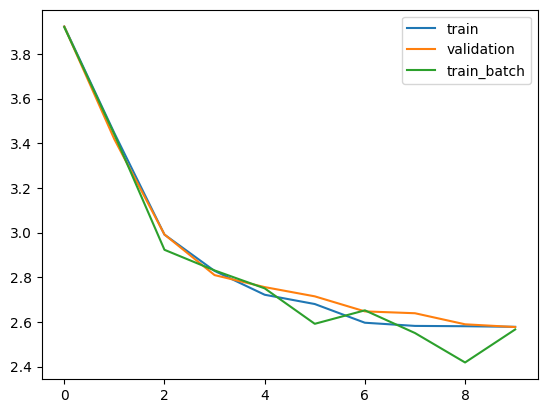

In [20]:
losses, state = train(model, optimizer=optax.adam(1e-3), deterministic=False)
pd.DataFrame(losses).plot()

## Generate

In [21]:
generate_rng = jax.random.PRNGKey(42)
def generate(model, params, config=MASTER_CONFIG, max_new_tokens=30):
    global generate_rng
    idx = jnp.ones((5, 1), dtype=jnp.int32)
    model.deterministic = True
    for _ in range(max_new_tokens):
        generate_rng, key = jax.random.split(generate_rng)
        # The model can only take max context window size input due to RMSNorm.
        inputs = idx[:, -config['context_window']:]
        logits = model.apply({'params': params}, inputs)
        last_time_step_logits = logits[:, -1, :]
        idx_next = jax.random.categorical(key, last_time_step_logits)
        idx_next = idx_next[:, None]
        idx = jnp.concatenate([idx, idx_next], axis=-1)
    return decode_tf(idx)

In [22]:
generate(model, state.params)

<tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'\nAYnt acer s wern, tare t\nIhe h',
       b"\nWho n kef R's morn b;\nWheEPatt",
       b'\nL.\nJfe b keseve bead hoovele, ',
       b'\n, Whevens tho, d t p hr s m as',
       b'\nWs tocst I tthe kind iea-EI be'], dtype=object)>

## LLaMA Specifics

1. RMSNorm for pre-normalization
2. Rotary embeddings
3. SwiGLU activation function

### RMSNorm

Applies the RMSNorm before the attention layer instead of after.

The RMSNorm is along the Sequence and Embedding dimensions.

In [23]:
class RMSNorm(nn.Module):
    config: dict

    @nn.compact
    def __call__(self, x):
        """Assume shape is [batch, seq, d_model]."""
        input_shape = x.shape
        scale = self.param('scale', lambda rng, shape: jnp.ones(shape), (self.config['context_window'], input_shape[-1]))
        ff_rms = jnp.linalg.norm(x, axis=(1, 2)) * x[0].size ** -0.5
        ff_rms = ff_rms[:, None, None]
        return scale[None, :input_shape[1], ...] * x / ff_rms

rms_norm = RMSNorm({'context_window': 3})
variables = rms_norm.init(jax.random.PRNGKey(42), jnp.ones((2, 3, 5)))
output = rms_norm.apply(variables, jnp.ones((2, 3, 5)) * 100)

jnp.allclose(jnp.linalg.norm(output, axis=(1, 2)),  jnp.ones((2,)) * jnp.sqrt(3 * 5))

Array(True, dtype=bool)

In [24]:
class SimpleModelRMS(nn.Module):
  config: dict
  deterministic: Optional[bool] = None

  @nn.compact
  def __call__(self, x, deterministic=None):
    deterministic = nn.merge_param('deterministic', self.deterministic, deterministic)
    x = nn.Embed(self.config['vocab_size'], self.config['d_model'])(x)
    x = RMSNorm(self.config)(x)
    x = nn.Sequential([
        nn.Dense(self.config['d_model'], name='FirstDense'),
        nn.relu,
        nn.Dense(self.config['vocab_size'], name='SecondDense')
    ], name='FirstSequential')(x)

    return x

model2 = SimpleModelRMS(MASTER_CONFIG)
variables = initialize(jax.random.PRNGKey(42), model2)
print("Total number of parameters:", count_params(variables))
print(model2.tabulate(jax.random.PRNGKey(42), jnp.ones((2, 3), dtype=jnp.int32), deterministic=True))

Total number of parameters: 35522

                             SimpleModelRMS Summary                             
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ path          ┃ module        ┃ inputs        ┃ outputs      ┃ params        ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│               │ SimpleModelR… │ - int32[2,3]  │ float32[2,3… │               │
│               │               │ -             │              │               │
│               │               │ deterministi… │              │               │
│               │               │ True          │              │               │
├───────────────┼───────────────┼───────────────┼──────────────┼───────────────┤
│ Embed_0       │ Embed         │ int32[2,3]    │ float32[2,3… │ embedding:    │
│               │               │               │              │ float32[66,1… │
│               │               │               │              │          

{'vocab_size': 66, 'batch_size': 32, 'context_window': 16, 'd_model': 128, 'steps': 200, 'log_interval': 20, 'n_heads': 8, 'n_layers': 4}


validation loss:  2.5219462


<Axes: >

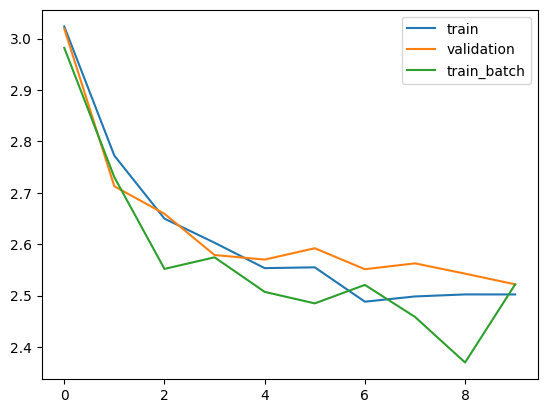

In [ ]:
losses, state2 = train(model2, optax.adam(1e-3), dict(MASTER_CONFIG, steps=200))
pd.DataFrame(losses).plot()

In [ ]:
generate(model2, state2.params)

<tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'\nI COLAS:\nHAeed pe? toeackeroBe',
       b"\nWin iveord 'bens, ordres hesea",
       b'\nClmatsto roondanothethar n arr',
       b'\n\nSINGoumagotimus wnofr gor or ',
       b"\n;\nANI adendr gleathart ' his d"], dtype=object)>

### Rotary Embeddings Attentions

RoPE is from [Reformer](https://arxiv.org/pdf/2104.09864.pdf).


Calling get_rotary_matrix (3, 5).


Array(True, dtype=bool)

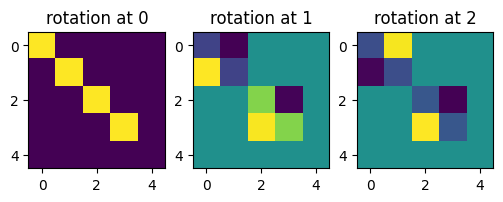

In [25]:
import functools
from matplotlib import pyplot as plt

@functools.cache
def get_rotary_matrix(context_window, embedding_dim):
    print(f"Calling get_rotary_matrix ({context_window}, {embedding_dim}).")
    R = np.zeros((context_window, embedding_dim, embedding_dim))
    for position in range(context_window):
        for i in range(embedding_dim//2):
            theta = 10000. ** (-2.*(i - 1) / embedding_dim)
            m_theta = position * theta
            R[position, 2*i,2*i] = np.cos(m_theta)
            R[position, 2*i,2*i+1] = - np.sin(m_theta)
            R[position, 2*i+1,2*i] = np.sin(m_theta)
            R[position, 2*i+1,2*i+1] = np.cos(m_theta)
    return R

R = get_rotary_matrix(3, 5)
fig, ax = plt.subplots(1, 3, figsize=(3 * 2, 1 * 2))
for i in range(3):
  ax[i].imshow(R[i, :, :])
  ax[i].set_title(f'rotation at {i}')

jnp.allclose(R[1,:] @ jnp.ones(5) @ R[2,:] @ jnp.ones(5), jnp.ones(5) @ R[2-1,:] @ jnp.ones(5))

Num params: 75
True


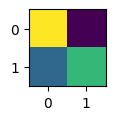

In [26]:
class RoPEAttentionHead(nn.Module):
    config: dict
    deterministic: bool = True
    causal: bool = True

    @nn.compact
    def __call__(self, x, return_attn_weights=False):
        b, m, d = x.shape
        # R = self.param('rotary_position', lambda key, d: get_rotary_matrix(self.config['context_window'], d), d)
        # R = jax.lax.stop_gradient(R)
        R = get_rotary_matrix(self.config['context_window'], d)
        q = nn.Dense(d, use_bias=False, name='w_q')(x)
        k = nn.Dense(d, use_bias=False, name='w_k')(x)
        v = nn.Dense(d, use_bias=False, name='w_v')(x)
        q = q.transpose(1, 0, 2) @ R[:m]
        q = q.transpose(1, 0, 2)
        k = k.transpose(1, 0, 2) @ R[:m]
        k = k.transpose(1, 0, 2)

        raw_attn_weights = q @ k.transpose(0, 2, 1) / jnp.sqrt(d)
        if self.causal:
            attn_mask = (jnp.tril(jnp.ones((m, m))) - 1) * 1e8
            raw_attn_weights += attn_mask
        raw_attn_weights = nn.softmax(raw_attn_weights, axis=-1)
        attn_weights = nn.Dropout(rate=0.1, deterministic=self.deterministic)(raw_attn_weights)

        activations = attn_weights @ v
        if return_attn_weights:
            return activations, raw_attn_weights
        return activations


rope_attn = RoPEAttentionHead({'context_window': 3})
vars = rope_attn.init(jax.random.PRNGKey(42), jnp.ones((2, 3, 5)))
print("Num params:", count_params(vars))

# Calling jax.jit will avoid re-computing rotary embedding.
@jax.jit
def rope_attn_forward(vars, x, **kwargs):
    return rope_attn.apply(vars, x, return_attn_weights=True)

activations, attn_weights = rope_attn_forward(vars, jnp.ones((2, 1, 5)))
activations, attn_weights = rope_attn_forward(vars, jnp.ones((2, 1, 5))*2)
activations, attn_weights = rope_attn_forward(vars, jnp.ones((2, 1, 5))*3)
activations, attn_weights = rope_attn_forward(vars, jnp.ones((2, 1, 5))*5)
print(jnp.allclose(attn_weights, jnp.ones((2, 1, 1))))

activations, attn_weights = rope_attn_forward(vars, jnp.ones((1, 2, 5)))
fig, ax = plt.subplots(figsize=(1, 1))
ax.imshow(attn_weights[0])


                         RoPEMultiheadAttention Summary                         
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ path          ┃ module        ┃ inputs        ┃ outputs      ┃ params        ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│               │ RoPEMultihea… │ float32[2,3,… │ float32[2,3… │               │
├───────────────┼───────────────┼───────────────┼──────────────┼───────────────┤
│ w_q           │ Dense         │ float32[2,3,… │ float32[2,3… │ kernel:       │
│               │               │               │              │ float32[5,30] │
│               │               │               │              │               │
│               │               │               │              │ 150 (600 B)   │
├───────────────┼───────────────┼───────────────┼──────────────┼───────────────┤
│ w_k           │ Dense         │ float32[2,3,… │ float32[2,3… │ kernel:       │
│               │          

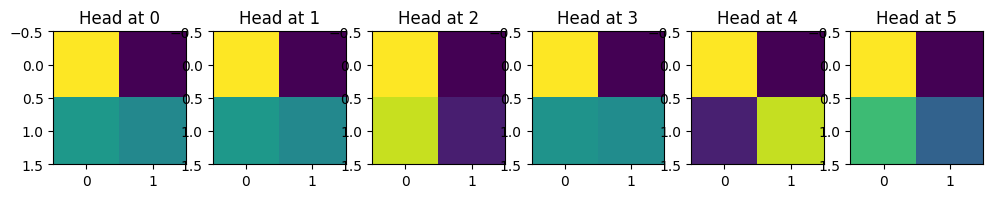

In [27]:
class RoPEMultiheadAttention(nn.Module):
    config: dict
    deterministic: bool = True
    # Create self attention mask.
    causal: bool = True
    use_multihead_dense: bool = True

    @nn.compact
    def __call__(self, x, return_attn_weights=False):
        b, m, d = x.shape
        # R = self.param('rotary_position', lambda key, d: get_rotary_matrix(self.config['context_window'], d), d)
        # R = jax.lax.stop_gradient(R)
        R = get_rotary_matrix(self.config['context_window'], d)
        n_heads = self.config['n_heads']
        q = nn.Dense(n_heads * d, use_bias=False, name='w_q')(x)
        k = nn.Dense(n_heads * d, use_bias=False, name='w_k')(x)
        v = nn.Dense(n_heads * d, use_bias=False, name='w_v')(x)
        q = q.reshape((b, m, n_heads, d)) @ R[:m]
        k = k.reshape((b, m, n_heads, d)) @ R[:m]
        v = v.reshape((b, m, n_heads, d))

        # [b, n_heads, m, m].
        raw_attn_weights = q.transpose(0, 2, 1, 3) @ k.transpose(0, 2, 3, 1) / jnp.sqrt(d)
        if self.causal:
            attn_mask = (jnp.tril(jnp.ones((m, m))) - 1) * 1e8
            raw_attn_weights += attn_mask
        raw_attn_weights = nn.softmax(raw_attn_weights, axis=-1)
        attn_weights = nn.Dropout(rate=0.1, deterministic=self.deterministic)(raw_attn_weights)

        # [b, n_heads, m, d].
        activations = attn_weights @ v.transpose(0, 2, 1, 3)
        activations = activations.transpose(0, 2, 1, 3).reshape((b, m, -1))
        if self.use_multihead_dense:
            activations = nn.Dense(d, name='multihead_dense')(activations)
            activations = nn.Dropout(rate=0.1, deterministic=self.deterministic, name='multihead_dropout')(activations)
        if return_attn_weights:
            return activations, raw_attn_weights
        return activations

MASTER_CONFIG['n_heads'] = 8
rope_multihead_attn = RoPEMultiheadAttention(config={'n_heads': 6, 'context_window': 3})
vars = rope_multihead_attn.init(jax.random.key(42), jnp.ones((2, 3, 5)))
print(rope_multihead_attn.tabulate(jax.random.key(42), jnp.ones((2, 3, 5))))
activations, attn_weights = rope_multihead_attn.apply(vars, jnp.ones((2, 1, 5)), return_attn_weights=True)
print(jnp.allclose(attn_weights, jnp.ones((2, 6, 1, 1))))

single_attn = RoPEAttentionHead(config={'n_heads': 1, 'context_window': 2})
rope_multihead_attn = RoPEMultiheadAttention(config={'n_heads': 1, 'context_window': 2}, use_multihead_dense=False)
vars = rope_multihead_attn.init(jax.random.key(42), jnp.ones((1, 2, 3)))
print("Single and multihead should equal when n_heads is 1: ",
      jnp.allclose(rope_multihead_attn.apply(vars, jnp.ones((1, 2, 3))),
                   single_attn.apply(vars, jnp.ones((1, 2, 3)))))

rope_multihead_attn = RoPEMultiheadAttention(config={'n_heads': 6, 'context_window': 3})
vars = rope_multihead_attn.init(jax.random.key(42), jnp.ones((2, 3, 5)))
activations, attn_weights = rope_multihead_attn.apply(vars, jnp.ones((1, 2, 5)), return_attn_weights=True)
print("Output shape: ", activations.shape)
fig, ax = plt.subplots(1, 6, figsize=(6 * 2, 1 * 2))
for i in range(6):
    ax[i].imshow(attn_weights[0, i])
    ax[i].set_title(f'Head at {i}')

If not causal, it is cheating and having low loss but not generating anything.

In [28]:
class RopeModel(nn.Module):
  config: dict
  deterministic: Optional[bool] = None
  causal: bool = True

  @nn.compact
  def __call__(self, x, deterministic: Optional[bool] = None):
    deterministic = nn.merge_param('deterministic', self.deterministic, deterministic)

    x = nn.Embed(self.config['vocab_size'], self.config['d_model'], name='Embed')(x)

    x = RMSNorm(self.config, name='RMSNormAttn')(x)
    x = x + RoPEMultiheadAttention(self.config,
                                   causal=self.causal,
                                   deterministic=deterministic,
                                   name='RopeAttn')(x)

    x = RMSNorm(self.config, name='RMSNormSequential')(x)
    x = x + nn.Sequential([
        nn.Dense(self.config['d_model'], name='FirstDense'),
        nn.relu,
    ], name='FirstSequential')(x)

    x = nn.Dense(self.config['vocab_size'], name='LastDense')(x)

    return x

model3 = RopeModel(dict(MASTER_CONFIG), causal=False)
variables = model3.init(jax.random.PRNGKey(42),
                        jnp.ones((MASTER_CONFIG['batch_size'],
                                  MASTER_CONFIG['context_window']),
                                  dtype=jnp.int32),
                        deterministic=True)
print("Total number of parameters:", count_params(variables))
# print(model3.tabulate(jax.random.PRNGKey(42), jnp.ones((2, 3), dtype=jnp.int32), deterministic=True))

Calling get_rotary_matrix (16, 128).
Total number of parameters: 561986


{'vocab_size': 66, 'batch_size': 32, 'context_window': 16, 'd_model': 128, 'steps': 200, 'log_interval': 20, 'n_heads': 8, 'n_layers': 4}


validation loss:  0.21576111


<Axes: >

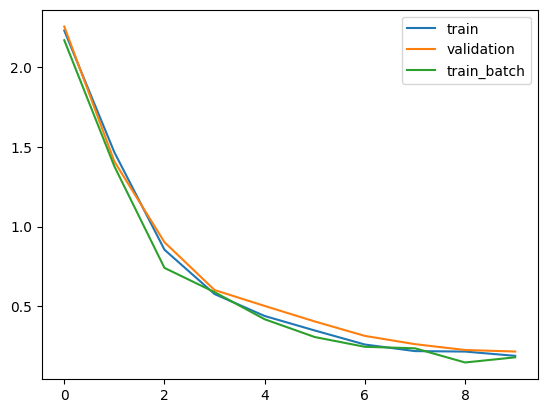

In [ ]:
MASTER_CONFIG['steps'] = 200
losses, state3 = train(model3, optax.adam(1e-3))
pd.DataFrame(losses).plot()

In [ ]:
generate(model3, state3.params)

<tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n',
       b'\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n',
       b'\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n',
       b'\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n',
       b'\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n'],
      dtype=object)>

Total number of parameters: 561986
{'d_model': 128, 'batch_size': 32, 'context_window': 16, 'vocab_size': 66, 'steps': 200, 'log_interval': 20, 'n_heads': 8, 'n_layers': 4}


validation loss:  2.231239


<Axes: >

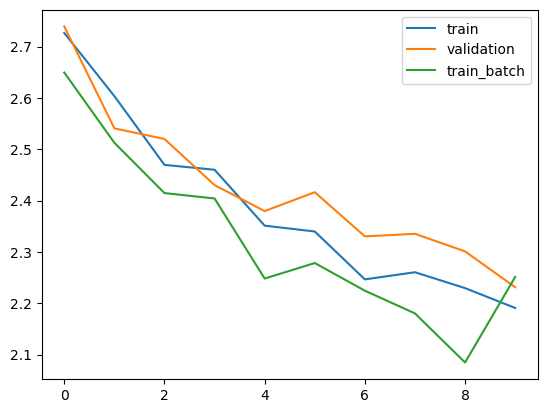

In [38]:
model4 = RopeModel(MASTER_CONFIG, causal=True)
variables = model4.init(jax.random.PRNGKey(42),
                        jnp.ones((MASTER_CONFIG['batch_size'],
                                  MASTER_CONFIG['context_window']),
                                  dtype=jnp.int32),
                        deterministic=True)
print("Total number of parameters:", count_params(variables))

losses, state4 = train(model4, optax.adam(1e-3), deterministic=False)
pd.DataFrame(losses).plot()

In [ ]:
# jnp.allclose(state4.params['RopeAttn']['rotary_position'], get_rotary_matrix(16, 128))

Array(True, dtype=bool)

In [ ]:
generate(model4, state4.params)

<tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'\nHOUECESHHAUQGes:\nORToor hate u',
       b'\nIOSSUCH:\nIFl Wour for sor for ',
       b'\nORGLAULIONLOASayUCY:\nESUw?\n\n\n\n',
       b'\nty, au, Sck chaurfouled hamlen',
       b'\nrand to so gadaw woutorukoo\nDi'], dtype=object)>

### SwiGLU

https://arxiv.org/abs/2002.05202v1

To use SwiGLU, we need to double the previous layers output d_model dimension size. Half of them would use as the gate logits.


                            SwiGLU Summary                            
┏━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ path ┃ module ┃ inputs         ┃ outputs        ┃ params           ┃
┡━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│      │ SwiGLU │ float32[2,3,6] │ float32[2,3,3] │ beta: float32[1] │
│      │        │                │                │                  │
│      │        │                │                │ 1 (4 B)          │
├──────┼────────┼────────────────┼────────────────┼──────────────────┤
│      │        │                │          Total │ 1 (4 B)          │
└──────┴────────┴────────────────┴────────────────┴──────────────────┘
                                                                      
                      Total Parameters: 1 (4 B)                       




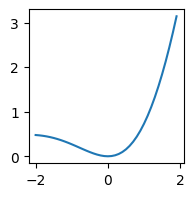

In [29]:
class SwiGLU(nn.Module):

    @nn.compact
    def __call__(self, x):
        beta = self.param("beta", nn.initializers.ones, (1,))
        x, gate = jnp.split(x, 2, axis=-1)

        swish_gate = gate * nn.sigmoid(beta * gate)
        return swish_gate * x

swiglu = SwiGLU()
print(swiglu.tabulate(jax.random.key(42), jnp.ones((2, 3, 6))))

x = jnp.arange(-2, 2, 0.1)
vars = swiglu.init(jax.random.key(42), jnp.ones((2, 2)))
y = swiglu.apply(vars, jnp.repeat(x[:, None], 2, axis=-1))
fig, ax = plt.subplots(1, figsize=(2, 2))
ax.plot(x, y)

In [30]:
class RopeModel2(nn.Module):
  config: dict
  deterministic: Optional[bool] = None
  causal: bool = True

  @nn.compact
  def __call__(self, x, deterministic: Optional[bool] = None):
    deterministic = nn.merge_param('deterministic', self.deterministic, deterministic)

    x = nn.Embed(self.config['vocab_size'], self.config['d_model'], name='Embed')(x)

    x = RMSNorm(self.config, name='RMSNormAttn')(x)
    x = x + RoPEMultiheadAttention(self.config,
                                   causal=self.causal,
                                   deterministic=deterministic,
                                   name='RopeAttn')(x)

    x = RMSNorm(self.config, name='RMSNormSequential')(x)
    x = x + nn.Sequential([
        nn.Dense(self.config['d_model'] * 2, name='FirstDense'),
        SwiGLU(name='SwiGLU'),
    ], name='FirstSequential')(x)

    x = nn.Dense(self.config['vocab_size'], name='LastDense')(x)

    return x

model5 = RopeModel2(MASTER_CONFIG)
variables = model5.init(jax.random.PRNGKey(42),
                        jnp.ones((MASTER_CONFIG['batch_size'],
                                  MASTER_CONFIG['context_window']),
                                  dtype=jnp.int32),
                        deterministic=True)
print("Total number of parameters:", count_params(variables))
# print(model5.tabulate(jax.random.PRNGKey(42), jnp.ones((2, 3), dtype=jnp.int32), deterministic=True))

Total number of parameters: 578499


{'vocab_size': 66, 'batch_size': 32, 'context_window': 16, 'd_model': 128, 'steps': 200, 'log_interval': 20, 'n_heads': 8, 'n_layers': 4}


validation loss:  2.2355876


<Axes: >

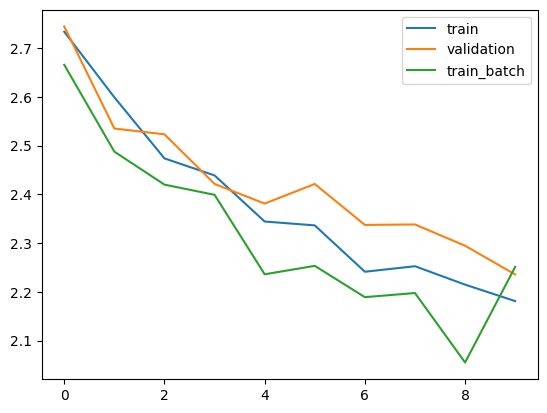

In [ ]:
losses, state5 = train(model5, optax.adam(1e-3))
pd.DataFrame(losses).plot()

In [ ]:
generate(model5, state5.params)

<tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'\nApsthalovesteon perst thre gwi',
       b'\nNINORCH:\nKE:\nI, beall couldlas',
       b'\nNogoordsoze, est he mare hou w',
       b'\nPOLINCEMANENNENNCENIIARDY:\nI, ',
       b'\nTo the belded; fat Rher nom im'], dtype=object)>

### LLaMA Block

In [31]:
class LlamaBlock(nn.Module):
    config: dict
    deterministic: Optional[bool] = None

    @nn.compact
    def __call__(self, x, deterministic: Optional[bool] = None):
        deterministic = nn.merge_param('deterministic', self.deterministic, deterministic)
        attn = RoPEMultiheadAttention(self.config, deterministic, name='attn')
        feedforward = nn.Sequential([
            nn.Dense(self.config['d_model'] * 2, name='ff_dense'),
            SwiGLU(name='swiglu'),
        ])

        x = RMSNorm(self.config, name='rms_attn')(x)
        x = x + attn(x)

        x = RMSNorm(self.config, name='rms_ff')(x)
        x = x + feedforward(x)
        return x

llamablock = LlamaBlock(MASTER_CONFIG)
# print(llamablock.tabulate(jax.random.key(42), jnp.ones((2, 3, 5)), deterministic=True))

In [33]:
MASTER_CONFIG.update({
    'n_layers': 4,
})

class Llama(nn.Module):
    config: dict
    deterministic: Optional[bool] = None

    @nn.compact
    def __call__(self, x, deterministic: Optional[bool] = None):
        deterministic = nn.merge_param('deterministic', self.deterministic, deterministic)

        embedding = nn.Embed(self.config['vocab_size'], self.config['d_model'], name='embed')
        llama_blocks = nn.Sequential(
            [
                LlamaBlock(self.config, deterministic, name=f'llama_{i}')
                for i in range(self.config['n_layers'])
            ],
            name='llama_blocks'
        )
        ffn = nn.Sequential([
            nn.Dense(self.config['d_model'] * 2, name='dense'),
            SwiGLU(name='swiglu'),
            nn.Dense(self.config['vocab_size'], name='dense_vocab')
        ], name='ffn')

        x = embedding(x)
        x = llama_blocks(x)
        x = ffn(x)
        return x

llama = Llama(dict(MASTER_CONFIG, n_layers=1))
vars = llama.init(jax.random.key(42), jnp.ones((2, 3), dtype=jnp.int32), deterministic=True)
count_params(vars)

611524

{'vocab_size': 66, 'batch_size': 32, 'context_window': 16, 'd_model': 128, 'steps': 1000, 'log_interval': 100, 'n_heads': 8, 'n_layers': 1}


validation loss:  1.9497601


<Axes: >

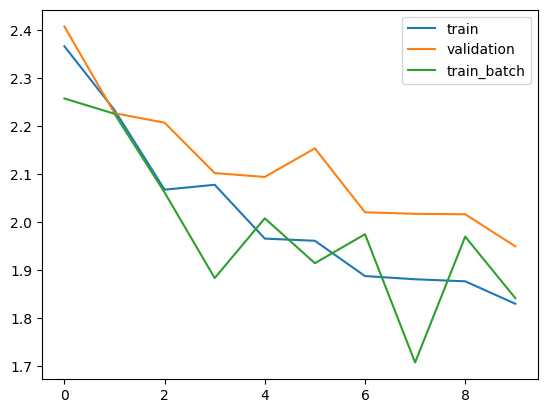

In [ ]:
losses, llama_state = train(llama, optax.adam(1e-3), config=dict(MASTER_CONFIG,
                                                                 n_layers=1,
                                                                 steps=1000,
                                                                 log_interval=100))
pd.DataFrame(losses).plot()

642500

In [ ]:
generate(llama, llama_state.params)

<tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'\nGorde is thuse busish in chars',
       b'\n\nDoin.\n\nGod O:\nDird\nMastoor?\n\n',
       b'\nFirson-vengine ouch\nKion our t',
       b'\nMy nood rie not.\n\nDUKE VINCENT',
       b'\nTo purse to be is thate of it '], dtype=object)>

{'vocab_size': 66, 'batch_size': 32, 'context_window': 16, 'd_model': 128, 'steps': 5000, 'log_interval': 100, 'n_heads': 8, 'n_layers': 4}


validation loss:  1.5465634


<Axes: >

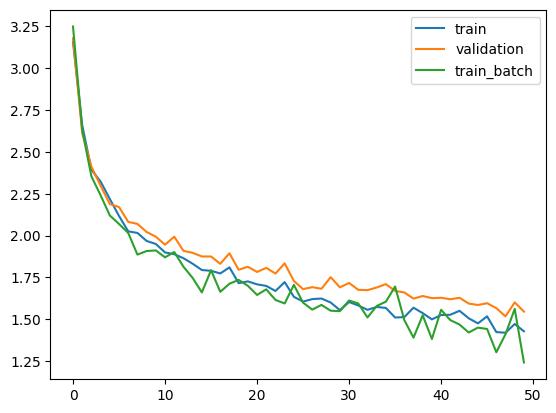

In [ ]:
llama2 = Llama(dict(MASTER_CONFIG, n_layers=4))
losses, llama_state2 = train(llama2, optax.adam(1e-3), config=dict(MASTER_CONFIG,
                                                                   steps=5000,
                                                                   log_interval=100
                                                                  ), deterministic=False)
pd.DataFrame(losses).plot()

In [ ]:
count_params(llama_state2.params)

2296135

In [ ]:
print(generate(llama2, llama_state2.params, max_new_tokens=200)[0].numpy().decode('utf-8'))



LEncENLUCESTIO:
Hy king, mig condaressing warry sit: satcize laws;
that
It noke fealis,
Untir givile not:
Your Come-peepy son
I do brease to the blind? 
Sweep what bewa vreaturn e
And murdered-pay, I


## Miscellaneous

### Check for Zero Weight

In [ ]:
# Print the percentage of params that are near 0.
def show_zero_weights(params, tol=1e-2):

    flattens, _ = jax.tree_util.tree_flatten_with_path(params)
    percentages = []
    for k, v in flattens:
        percentage = 100 * jnp.sum(jnp.abs(v) < tol) / v.size
        percentage = percentage.item()
        if percentage == 0:
            continue
        percentages.append((jax.tree_util.keystr(k), percentage))

    return sorted(percentages, key=lambda t: t[1], reverse=True)

show_zero_weights(llama_state3.params)[:10]

### Cosine Annealing Learning Rate Scheduler

{'d_model': 128, 'batch_size': 32, 'context_window': 16, 'vocab_size': 66, 'steps': 5000, 'log_interval': 250, 'n_heads': 8, 'n_layers': 4}


validation loss:  1.486564


<Axes: >

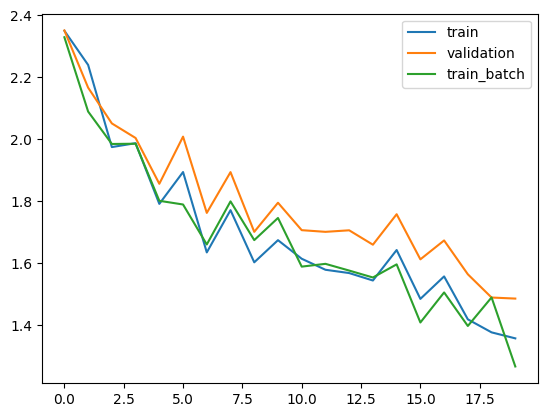

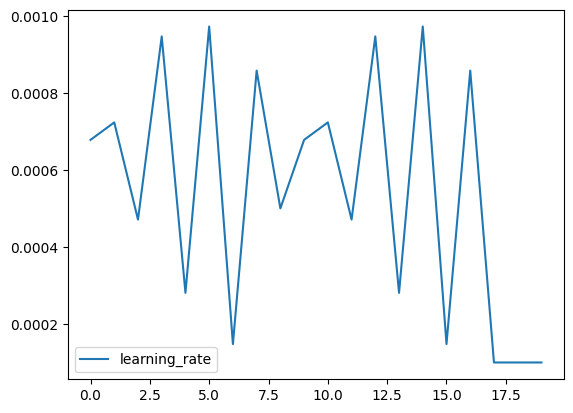

In [37]:
total_steps = 5000
num_cycles = 10
decay_steps = (total_steps - 500) // num_cycles
warmup_steps = decay_steps // 4

cosine_kwargs = [
    {
        "init_value": 5e-4,
        "peak_value": 1e-3,
        "warmup_steps": warmup_steps,
        "decay_steps": decay_steps,
        "end_value": 1e-4
    } for _ in range(num_cycles)]

cos_anneal_lr_fn = optax.sgdr_schedule(cosine_kwargs)


llama3 = Llama(dict(MASTER_CONFIG, n_layers=4))
metric_maps, llama_state3 = train(llama3, optax.adam(learning_rate=cos_anneal_lr_fn),
                             config=dict(MASTER_CONFIG,
                                         steps=total_steps,
                                         log_interval=total_steps // 20
                                        ),
                             deterministic=False,
                             lr_fn=cos_anneal_lr_fn)

losses, lrs = [], []
for metric_map in metric_maps:
    losses.append({})
    for key, value in metric_map.items():
        if key == 'learning_rate':
            lrs.append({key: value})
            continue
        losses[-1][key] = value
pd.DataFrame(losses).plot()
pd.DataFrame(lrs).plot()

In [39]:
print(generate(llama3, llama_state3.params, max_new_tokens=200)[0].numpy().decode('utf-8'))


GLOUCESTER:
Nor E?

CORIOLANUS:
Go:
Giffire; lord.

ENV:
Dow, sir, mader 'tis clifts,
My Poor blood's uppring
Lift!

GLOUCESTER:
Or, at May gets so.

SACINIUS:
Bole whom thy noble fariny?

PRINCE GBar
